$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# Recurrent Neural Networks

Remember our picture of a neural network with a single hidden layer?

<img src="http://www.cs.colostate.edu/~anderson/cs480/notebooks/nnTwoLayer.png">

This model produces an output for each sample present as an input vector.  This is fine when all of the information relevant for producing an approximately correct output is included in the input vector.  For some problems, this is not true.

Consider the problem of predicting whether the price of a stock will go up or down in the next hour.  You can come up with a detailed characterization of the state of the stock market (and related economies around the world) and present this as the input vector.  However, knowing the activity in the stock market (and the whole world) in the recent past could help tremendously in making a good prediction.

How much of the past should you include?  What aspects of the past should you include?  Is there any way to make our network figure out the answers to these questions?

In a limited way, the answer is yes.  By adding dynamics to the calculations of the hidden units, these units can learn to remember activity from past inputs.  Dynamics are added by simply feeding the output of the hidden units back to the hidden units as inputs, making a cycle in the calculations.  Here's a picture.

<img src="http://www.cs.colostate.edu/~anderson/cs480/notebooks/nnTwoLayerRecurrent.png">

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \tilde{\Xv} \;\;\;\;\;\;\;\;\;\;\;\;$ 
$\;\;\;\;\;\;\;\;\;\;\;\; \Vv \;\;\;\;\;\;\;\;\;\;\;\;$
$\;\;\;\;\; \tilde{\Zv} \;\;\;\;\;\;\;\;\;\;\;\;$ 
$\;\;\;\;\;\;\;\;\;\;\;\; \Wv \;\;\;\;\;\;\;\;\;\;\;\;$ 
$\;\;\;\;\;\;\;\;\; \Yv \;\;\;\;\;\;\;\;\;\;\;\;$

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; N \times (D+1) \;$
$\;\;\;\;(D+1)+M \times M $
$\; N \times (M+1) \;\;\;\;\;$
$\;\;\;\;\;(M+1)\times K\;\;\;\; \;$
$\;\;\;\;\; N \times K$

$$
\begin{align*}
\tilde{\Zv} & = h([\tilde{\Xv},\Zv^{previous}] \Vv),\\
\Yv & = \tilde{\Zv} \Wv, \text{ or }\\
\Yv & = \tilde{h}([\tilde{\Xv},\Zv^{previous}] \Vv) \Wv 
\end{align*}
$$

$\Zv^{previous}$ is the output value of the hidden units on the previous time step.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

In [2]:
!wget http://www.cs.colostate.edu/~anderson/cs480/notebooks/scg.tar

--2017-02-20 08:09:38--  http://www.cs.colostate.edu/~anderson/cs480/notebooks/scg.tar
Resolving www.cs.colostate.edu (www.cs.colostate.edu)... 129.82.45.114
Connecting to www.cs.colostate.edu (www.cs.colostate.edu)|129.82.45.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30720 (30K) [application/x-tar]
Saving to: ‘scg.tar.2’

scg.tar.2           100%[===================>]  30.00K   170KB/s    in 0.2s    

2017-02-20 08:09:38 (170 KB/s) - ‘scg.tar.2’ saved [30720/30720]



In [3]:
!tar xvf scg.tar

scaledconjugategradient.py
mlutils.py


## Neural Network Recurrent Class

In [9]:
%%writefile neuralnetworksrecurrent.py

import numpy as np
import scaledconjugategradient as scg
import mlutils as ml  # for draw()
from copy import copy

class NeuralNetworkRecurrent:

    def __init__(self, ni, nh, no):
        self.V = 1/np.sqrt(1+ni+nh) * np.random.uniform(-1, 1, size=(ni+1+nh, nh))
        self.W = 1/np.sqrt(1+nh) *  np.random.uniform(-1, 1, size=(1+nh, no))
        self.ni, self.nh, self.no = ni, nh, no
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.trained = False
        self.reason = None
        self.errorTrace = None
        self.numberOfIterations = None

    # Return printed representation of NeuralNetworkRecurrent instance.
    def __repr__(self):
        str = 'BPTT({}, {}, {})'.format(self.ni, self.nh, self.no)
        if self.trained:
            str += '\n   Network was trained for {} iterations. Final error is {}.'.format(self.numberOfIterations, 
                                                                                           self.errorTrace[-1])
        else:
            str += '  Network is not trained.'
        return str
            
    # Standardization functions for input, X, and for target, T.
    def standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result
    def unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans
    def standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result
    def unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans
        
    # Train the network, given inputs, X, targets, T, number of iterations, and precisions used to stop early.
    def train(self, X, T, nIterations=100, verbose=False,  weightPrecision=0, errorPrecision=0, newData=False):
        
        if self.Xmeans is None:
            # Calculate and store the means and standard deviations for each input variable,  or column of X.
            # Set the standard deviation to 1 for any column that has a constant value across samples,  
            #   which would result in a standard deviation of 0. 
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1
        # Standardize all input samples in X.
        X = self.standardizeX(X)

        # If T is given as a one-dimensional vector,  reshape it to be a column matrix. Later matrix expressions require this.
        if T.ndim == 1:
            T = T.reshape((-1, 1))

        if self.Tmeans is None:
            # Calculate and store the means and standard deviations for each target variable,  or column of T.
            # Set the standard deviation to 1 for any column that has a constant value across samples, 
            #    which would result in a standard deviation of 0.
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
        # Standardize all target variables.
        T = self.standardizeT(T)

        # Allocate memory for main matrix results for later matrix calculations.
        if not self.trained or not newData:
            self.Zprev = np.zeros((1, self.nh))
        nSamples = X.shape[0]
        self.Z = np.zeros((nSamples, self.nh))
        self.Y = np.zeros((nSamples, self.no))
        self.delta = np.zeros((nSamples, self.nh))

        # Return one-dimensional vector containing all weights in hidden and output layers.
        # For use in by scg.scg().
        def pack(V, W):
            return np.hstack((V.flat, W.flat))

        # Fill neural net weight matrices,  V and W,  with values from one-dimensional vector given as argument.
        # For use by scg.scg().
        def unpack(w):
            first = 0
            numInThisLayer = self.ni + self.nh
            self.V[:] = w[:(numInThisLayer+1)*self.nh].reshape((numInThisLayer+1, self.nh))
            first += (numInThisLayer+1) * self.nh
            self.W[:] = w[first:].reshape((self.nh+1, self.no))

        # Given one-dimensional vector of all weights,  do forward pass through the network and calculate and return
        # the mean squared error.
        # For use by scg.scg().
        def objectiveF(w):
            unpack(w)
            self.Z[0, :] = np.tanh(np.dot( np.hstack((X[0:1, :],  self.Zprev)),  self.V[1:, :]) + self.V[0:1, :])
            for n in range(1, nSamples):
                self.Z[n, :] = np.tanh(np.dot( np.hstack((X[n:n+1, :],  self.Z[n-1:n, :])),  self.V[1:, :]) + self.V[0:1, :])
            self.Y = np.dot(self.Z,  self.W[1:, :]) + self.W[0:1, :]
            return np.mean((T-self.Y)**2)

        # Given one-dimensional vector of all weights,  do forward pass through the network and calculate and return
        # the gradient with respect to all weights of the mean squared error.
        # For use by scg.scg().
        def gradF(w):
            unpack(w)
            # Forward Pass
            self.Z[0, :] = np.tanh(( np.hstack((X[0:1, :], self.Zprev)) @  self.V[1:, :]) + self.V[0:1, :])
            for n in range(1, nSamples):
                self.Z[n, :] = np.tanh(( np.hstack((X[n:n+1, :], self.Z[n-1:n, :])) @ self.V[1:, :]) + self.V[0:1, :])
            self.Y = (self.Z @ self.W[1:, :]) + self.W[0:1, :]

            # Output layer error
            deltaOutput = -(T - self.Y)  / (X.shape[0] * T.shape[1])
            # Calculate the gradient of the error with respect to the output layer weights, W.
            dW = 2 * np.vstack((np.ones((1, deltaOutput.shape[0])) @ deltaOutput, self.Z.T @ deltaOutput))
            # Error, delta, to be back-propagated from output layer.
            self.delta[-1, :] = (1 - self.Z[-1:, :]**2) * ( deltaOutput[-1:, :] @ self.W[1:, :].T )
            # Back-propagate errors, delta, through recurrent connections, as if recurrent layer is unrolled in time.
            for n in range(nSamples-2, -1, -1):
                self.delta[n, :] = (1 - self.Z[n:n+1, :]**2) * ( ( deltaOutput[n:n+1, :] @ self.W[1:, :].T ) +
                                                                 ( self.delta[n+1:n+2, :] @ self.V[self.ni+1:, :].T) )
            # Calculate the gradient of the error with respect to the recurrent layer weights, V, after summing all back-propagated deltas.
            dV = 2 * np.vstack(( np.ones((1, self.delta.shape[0])) @ self.delta , 
                                 np.hstack((X, self.Z)).T @ self.delta))
            # Return the gradients of the mean squared error with respect to recurrent weights, V, and output layer weights, W.
            return pack(dV, dW)

        # Perform the iterative minimization of the mean squared error using the Scaled Conjugate Gradient algorithm, in scg.scg().
        scgresult = scg.scg(pack(self.V, self.W),  objectiveF,  gradF, 
                            xPrecision = weightPrecision, 
                            fPrecision = errorPrecision, 
                            nIterations = nIterations, 
                            verbose=verbose, 
                            ftracep=True)

        # Save the state of the recurrent layer units to be used when use() is called.
        self.Zprev = self.Z[-1:, :]
        
        unpack(scgresult['x'])
        self.reason = scgresult['reason']
        self.errorTrace = np.hstack((self.errorTrace, np.sqrt(scgresult['ftrace']))) # * self.Tstds # to unstandardize the MSEs
        self.numberOfIterations = len(self.errorTrace)
        self.trained = True
        return self

    # Do forward pass through the network, after standardizing input variables, X.
    def use(self, X, allOutputs=False):
        X = self.standardizeX(X)
        # First input sample to recurrent layer is composed of first sample in X concatenated with current state of recurrent units' outputs.
        self.Z[0, :] = np.tanh(( np.hstack((X[0:1, :], self.Zprev)) @ self.V[1:, :] ) + self.V[0:1, :])
        # Calculate the output of the recurrent units for each sample, by looping through each sample in X, concatenating with each the
        # previous step's output of the recurrent units.
        nSamples = X.shape[0]
        for n in range(1, nSamples):
            self.Z[n, :] = np.tanh(( np.hstack((X[n:n+1, :], self.Z[n-1:n, :])) @ self.V[1:, :]) + self.V[0:1, :])
        # Calculate the output of the output layer units.
        self.Y = (self.Z @ self.W[1:, :]) + self.W[0:1, :]
        self.Y = self.unstandardizeT(self.Y)
        self.Zprev = self.Z[-1:, :]
        return self.Y, self.Z if allOutputs else self.Y

    def getNumberOfIterations(self):
        return self.numberOfIterations
    
    def getErrors(self):
        return self.errorTrace
        
    def draw(self, inputNames = None,  outputNames = None):
        ml.draw(self.Vs,  self.W,  inputNames,  outputNames)

Overwriting neuralnetworksrecurrent.py


In [10]:
import neuralnetworksrecurrent as nnrec
import imp
imp.reload(nnrec)

<module 'neuralnetworksrecurrent' from '/home/anderson/Downloads/neuralnetworksrecurrent.py'>

In [37]:
def run(X,T,hiddenUnits,nIterations=100,nRepetitions=10):
    nnet = nnrec.NeuralNetworkRecurrent(X.shape[1],hiddenUnits,T.shape[1])
    
    fig = plt.figure(figsize=(10,15))

    for rep in range(nRepetitions):
        nnet.train(X,T,nIterations=nIterations)
        Y,Z = nnet.use(X,allOutputs=True)
        
        plt.clf()
        plt.subplot(8,1,1)
        plt.plot(X[:,0],'o-')
        plt.legend(('Input 1',),loc='upper right')
        plt.ylim(-0.1,1.1)
        plt.subplot(8,1,2)
        plt.plot(X[:,1],'o-')
        plt.ylim(-0.1,1.1)
        plt.legend(('Input 2',),loc='upper right')
        plt.subplot(8,1,(3,4))
        plt.plot(T,'o-')
        plt.plot(Y,'o-')
        plt.ylim(-0.1, 1.1)
        plt.legend(('Target','Prediction'),loc='best')
        plt.subplot(8,1,(5,6))
        plt.plot(Z,'.-')
        plt.ylim(-1.1,1.1)
        plt.ylabel('Zs')
        plt.subplot(8,1,(7,8))
        plt.plot(nnet.getErrors())
        ylims = plt.ylim()
        plt.legend(('RMSE',),loc='upper right')
        plt.ylim(0,ylims[1])
        
        ipd.clear_output(wait=True)
        ipd.display(fig)
        
    ipd.clear_output(wait=True)
    return nnet

Create a target that is 1 if two binary-valued input variables were equal two steps ago, if delay = 2.

In [26]:
X = np.random.choice([0,1],(10,2))
X

array([[0, 1],
       [1, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [0, 1],
       [0, 1]])

In [27]:
(X[:,0] == X[:,1]).reshape((-1,1))

array([[False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False]], dtype=bool)

In [28]:
(X[:,0] == X[:,1]).reshape((-1,1)).astype(int)

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [29]:
X = np.random.choice([0, 1], (50, 2))
delay = 2
T = (X[delay:,0] == X[delay:,1]).reshape((-1,1)).astype(int)
T = np.vstack((np.zeros((delay,1)), T))

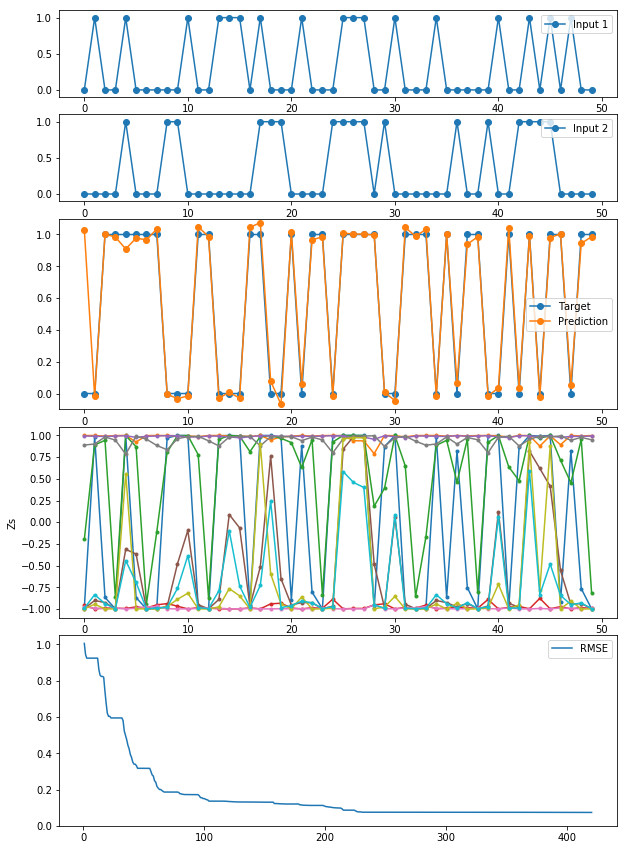

In [39]:
nnet = run(X,T,10, nIterations=20, nRepetitions=20)